In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [16]:
# import os
# print(os.getcwd())

In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

dataset_dir = r"../train_val"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# load and split
train_ds = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Found 830 files belonging to 2 classes.
Using 664 files for training.
Found 830 files belonging to 2 classes.
Using 166 files for validation.


# plot classes

In [18]:
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# save class names
class_names = train_ds_raw.class_names
print("Class names:", class_names)


AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_raw.prefetch(AUTOTUNE)
val_ds = val_ds_raw.prefetch(AUTOTUNE)

Found 830 files belonging to 2 classes.
Using 664 files for training.
Found 830 files belonging to 2 classes.
Using 166 files for validation.
Class names: ['activity_no', 'activity_yes']


In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = int(labels[i])
        plt.title(class_names[label])
        plt.axis("off")

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]] [Op:IteratorGetNext]

<Figure size 1200x800 with 0 Axes>

# model

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [25]:
# data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1),
])

In [26]:
# load base mobile net v2 model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    #weights=None,
    #weights='imagenet',
)
base_model.trainable = False  # freeze for transf learning

In [27]:
# build full model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid',
                       kernel_regularizer=regularizers.l2(0.001))(x)
model = tf.keras.Model(inputs, outputs)

In [28]:
# compile for transfer learning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# train
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=[early_stop]
)

Epoch 1/40
21/21 [==============================] - 27s 819ms/step - loss: 0.8719 - accuracy: 0.5120 - auc: 0.5188 - val_loss: 0.7887 - val_accuracy: 0.4880 - val_auc: 0.4389
Epoch 2/40
21/21 [==============================] - 14s 667ms/step - loss: 0.8048 - accuracy: 0.5437 - auc: 0.5832 - val_loss: 0.7502 - val_accuracy: 0.5060 - val_auc: 0.5025
Epoch 3/40
21/21 [==============================] - 14s 684ms/step - loss: 0.8157 - accuracy: 0.5512 - auc: 0.5696 - val_loss: 0.7169 - val_accuracy: 0.5783 - val_auc: 0.5605
Epoch 4/40
21/21 [==============================] - 13s 587ms/step - loss: 0.7618 - accuracy: 0.5783 - auc: 0.6251 - val_loss: 0.6868 - val_accuracy: 0.6024 - val_auc: 0.6239
Epoch 5/40
21/21 [==============================] - 13s 602ms/step - loss: 0.6925 - accuracy: 0.6205 - auc: 0.7029 - val_loss: 0.6620 - val_accuracy: 0.6084 - val_auc: 0.6745
Epoch 6/40
21/21 [==============================] - 12s 589ms/step - loss: 0.6876 - accuracy: 0.6325 - auc: 0.6989 - val_loss

# unfreeze

In [29]:
# unfreeze top layers for finetuning
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [30]:
# recompile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# train again
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=[early_stop]
)

Epoch 1/40
21/21 [==============================] - 24s 735ms/step - loss: 0.3915 - accuracy: 0.8855 - auc: 0.9521 - val_loss: 0.3747 - val_accuracy: 0.9096 - val_auc: 0.9562
Epoch 2/40
21/21 [==============================] - 14s 652ms/step - loss: 0.3973 - accuracy: 0.8870 - auc: 0.9498 - val_loss: 0.3631 - val_accuracy: 0.9337 - val_auc: 0.9594
Epoch 3/40
21/21 [==============================] - 14s 636ms/step - loss: 0.3902 - accuracy: 0.8901 - auc: 0.9538 - val_loss: 0.3535 - val_accuracy: 0.9337 - val_auc: 0.9612
Epoch 4/40
21/21 [==============================] - 14s 669ms/step - loss: 0.3682 - accuracy: 0.9006 - auc: 0.9638 - val_loss: 0.3515 - val_accuracy: 0.9277 - val_auc: 0.9630
Epoch 5/40
21/21 [==============================] - 14s 649ms/step - loss: 0.3543 - accuracy: 0.9262 - auc: 0.9685 - val_loss: 0.3461 - val_accuracy: 0.9337 - val_auc: 0.9639
Epoch 6/40
21/21 [==============================] - 13s 613ms/step - loss: 0.3563 - accuracy: 0.9127 - auc: 0.9675 - val_loss

In [31]:
def combine_histories(h1, h2):
    combined = {}
    for key in h1.history:
        combined[key] = h1.history[key] + h2.history[key]
    return combined

combined_history = combine_histories(history1, history2)

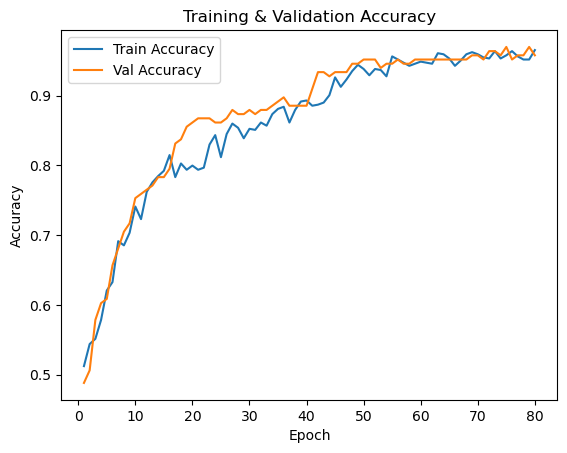

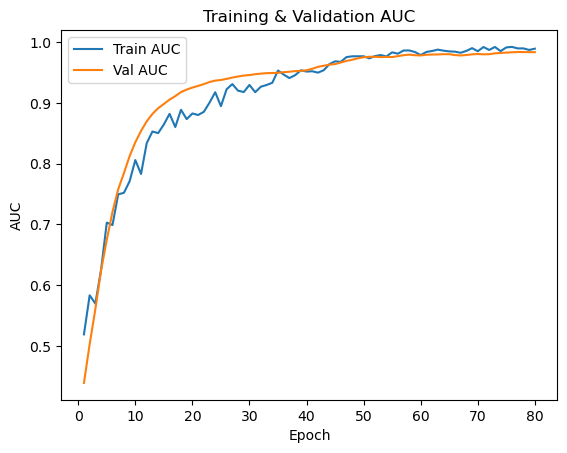

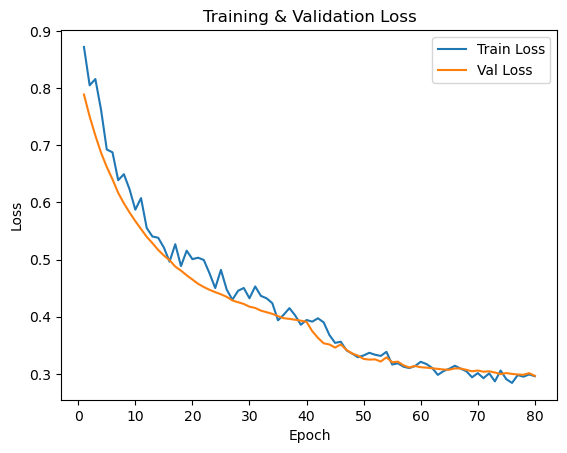

In [32]:
import matplotlib.pyplot as plt

epochs = range(1, len(combined_history['accuracy']) + 1)

# accuracy
plt.figure()
plt.plot(epochs, combined_history['accuracy'], label='Train Accuracy')
plt.plot(epochs, combined_history['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# AUC
plt.figure()
plt.plot(epochs, combined_history['auc'], label='Train AUC')
plt.plot(epochs, combined_history['val_auc'], label='Val AUC')
plt.title('Training & Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

# loss
plt.figure()
plt.plot(epochs, combined_history['loss'], label='Train Loss')
plt.plot(epochs, combined_history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# evaluate test performance

In [6]:
import tensorflow as tf

path_test = r"../test"

test_ds = tf.keras.utils.image_dataset_from_directory(
    path_test,
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

Found 118 files belonging to 2 classes.


In [7]:
results = model.evaluate(test_ds)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")
print(f"Test AUC: {results[2]:.4f}")

InvalidArgumentError: Graph execution error:

Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]] [Op:__inference_test_function_10688]

In [35]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = (y_pred_probs.flatten() > 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)

labels = ['No Activity', 'Activity']
cm_df = pd.DataFrame(cm, index=[f'True {label}' for label in labels],
                        columns=[f'Pred {label}' for label in labels])

print("Confusion Matrix:\n")
print(cm_df)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

4/4 [==============================] - 2s 404ms/step
Confusion Matrix:

                  Pred No Activity  Pred Activity
True No Activity                47             12
True Activity                    2             57

Classification Report:
              precision    recall  f1-score   support

 No Activity       0.96      0.80      0.87        59
    Activity       0.83      0.97      0.89        59

    accuracy                           0.88       118
   macro avg       0.89      0.88      0.88       118
weighted avg       0.89      0.88      0.88       118



# Grid search

In [1]:
import os
import warnings
import logging
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')
tf.get_logger().setLevel(logging.ERROR)

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from itertools import product
import pandas as pd
import os

# prep training and val data
dataset_dir = r"../train_val"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


os.makedirs("saved_models", exist_ok=True)

# data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1),
])

# params
dropout_rates = [0.3, 0.5]
l2_strengths = [0.001]
learning_rates = [0.001, 0.0005]
epoch_options = [5, 10]


results = []

def build_model(dropout_rate, l2_strength):
    base_model = tf.keras.applications.MobileNetV2(
        include_top=False, input_shape=(224, 224, 3), weights='imagenet'
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation='sigmoid',
                           kernel_regularizer=regularizers.l2(l2_strength))(x)

    model = tf.keras.Model(inputs, outputs)
    return model, base_model

# grid search and save all models
for dropout, l2_val, lr, epochs in product(dropout_rates, l2_strengths, learning_rates, epoch_options):
    print(f"\n🔍 Training: dropout={dropout}, l2={l2_val}, lr={lr}, epochs={epochs}")

    model, base_model = build_model(dropout, l2_val)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # train with frozen base model
    model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=2)

    # fine tune
    base_model.trainable = True
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr / 10),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    fine_tune_epochs = 3
    model.fit(train_ds, validation_data=val_ds, epochs=fine_tune_epochs, verbose=2)

    val_loss, val_acc = model.evaluate(val_ds, verbose=0)

    # save model
    model_name = f"model_d{dropout}_l2{l2_val}_lr{lr}_e{epochs + fine_tune_epochs}.h5"
    model.save(f"saved_models/{model_name}")
    print(f"💾 Saved model as {model_name}")

    results.append({
        'model': model_name,
        'dropout': dropout,
        'l2': l2_val,
        'lr': lr,
        'epochs': epochs + fine_tune_epochs,
        'val_accuracy': val_acc
    })

# save training resutls
df_results = pd.DataFrame(results)
df_results.to_csv("grid_search_results.csv", index=False)
print("\n models saved.")


Found 830 files belonging to 2 classes.
Using 664 files for training.
Found 830 files belonging to 2 classes.
Using 166 files for validation.

🔍 Training: dropout=0.3, l2=0.001, lr=0.001, epochs=5
Epoch 1/5


KeyboardInterrupt: 

Found 118 files belonging to 2 classes.

Best Model: model_d0.3_l20.001_lr0.001_e13.h5
4/4 [==============================] - 2s 360ms/step


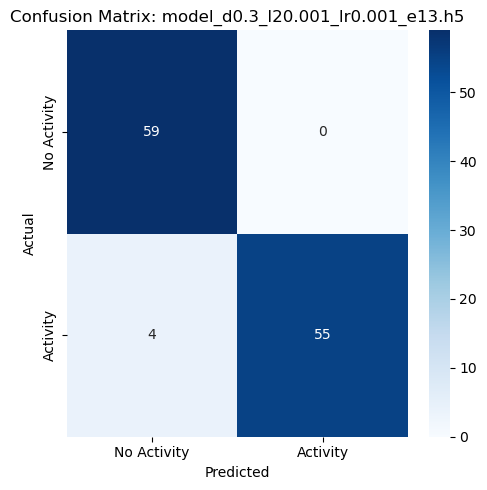


Classification Report:
              precision    recall  f1-score   support

 No Activity       0.94      1.00      0.97        59
    Activity       1.00      0.93      0.96        59

    accuracy                           0.97       118
   macro avg       0.97      0.97      0.97       118
weighted avg       0.97      0.97      0.97       118

Accuracy: 0.9661
Precision: 1.0
Recall: 0.9322
F1 Score: 0.9649


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

path_test = r"../test"

test_ds = tf.keras.utils.image_dataset_from_directory(
    path_test,
    image_size=(224, 224),
    batch_size=32,
    shuffle=False,
    label_mode='binary'
).prefetch(tf.data.AUTOTUNE)

y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

# get all model performances
df_eval = pd.read_csv("all_models_test_evaluation.csv")
best_model_file = df_eval.sort_values(by="test_accuracy", ascending=False).iloc[0]["model"]

# best modle
print(f"\nBest Model: {best_model_file}")

model_path = os.path.join("saved_models", best_model_file)
model = tf.keras.models.load_model(model_path)

y_pred_probs = model.predict(test_ds)
y_pred_labels = (y_pred_probs.flatten() > 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred_labels)
labels = ['No Activity', 'Activity']

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix: {best_model_file}')
plt.tight_layout()
plt.show()


print("\nClassification Report:")
print(classification_report(y_true, y_pred_labels, target_names=labels))

accuracy = accuracy_score(y_true, y_pred_labels)
precision = precision_score(y_true, y_pred_labels)
recall = recall_score(y_true, y_pred_labels)
f1 = f1_score(y_true, y_pred_labels)

print("Accuracy:", round(accuracy, 4))
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4))

# training curves best performing model

In [9]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, regularizers
import os


dataset_dir = r"../train_val"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)


df_test = pd.read_csv("all_models_test_evaluation.csv")
df_train = pd.read_csv("grid_search_results.csv")


best_model_name = df_test.sort_values(by="test_accuracy", ascending=False).iloc[0]["model"]

# get hyperparams
best_row = df_train[df_train["model"] == best_model_name].iloc[0]

dropout = float(best_row["dropout"])
l2_val = float(best_row["l2"])
lr = float(best_row["lr"])
total_epochs = int(best_row["epochs"])
fine_tune_epochs = 3
initial_epochs = total_epochs - fine_tune_epochs

print(f"Best model: {best_model_name}")
print(f"Using params -> dropout: {dropout}, l2: {l2_val}, lr: {lr}, epochs: {total_epochs}")


def build_model(dropout_rate, l2_strength):
    base_model = tf.keras.applications.MobileNetV2(
        include_top=False, input_shape=(224, 224, 3), weights='imagenet'
    )
    base_model.trainable = False

    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
        layers.RandomTranslation(0.1, 0.1),
    ])

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation='sigmoid',
                           kernel_regularizer=regularizers.l2(l2_strength))(x)

    model = tf.keras.Model(inputs, outputs)
    return model, base_model


model, base_model = build_model(dropout, l2_val)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


history1 = model.fit(train_ds, validation_data=val_ds, epochs=initial_epochs, verbose=2)


base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr / 10),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(train_ds, validation_data=val_ds, epochs=fine_tune_epochs, verbose=2)


def combine_history(h1, h2):
    combined = {}
    for key in h1.history:
        combined[key] = h1.history[key] + h2.history[key]
    return combined

combined_history = combine_history(history1, history2)


epochs_range = range(len(combined_history['accuracy']))

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, combined_history['accuracy'], label='Train Accuracy')
plt.plot(epochs_range, combined_history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, combined_history['loss'], label='Train Loss')
plt.plot(epochs_range, combined_history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Found 830 files belonging to 2 classes.
Using 664 files for training.
Found 830 files belonging to 2 classes.
Using 166 files for validation.
Best model: model_d0.3_l20.001_lr0.001_e13.h5
Using params -> dropout: 0.3, l2: 0.001, lr: 0.001, epochs: 13
Epoch 1/10


KeyboardInterrupt: 